# PACKAGES LOADING

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import bz2
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

from vgg_model import create_model
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from PIL import Image

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATA LOADING

In [3]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        try:
            for f in sorted(os.listdir(os.path.join(path, i))):
                # Check file extension. Allow only jpg/jpeg' files.
                ext = os.path.splitext(f)[1]
                if ext == '.jpg' or ext == '.JPG' or ext == '.jpeg':
                    metadata.append(IdentityMetadata(path, i, f))
        except NotADirectoryError:
            pass
    return np.array(metadata)

metadata = load_metadata('images/train_images')

# FACE DETECTION

We will use Haar filter as part of Viola Jones algorithm to detect faces. in an image. We load a *XML* file containing Haar file descriptors for facial detection

In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [6]:
img = cv2.imread(metadata[37].image_path())
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [7]:
faces = face_cascade.detectMultiScale(gray)

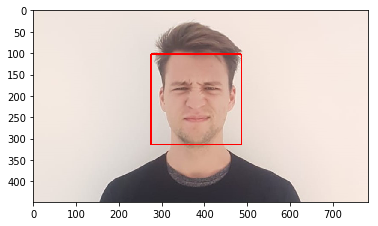

In [8]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), 255, 2)

plt.figure()
plt.imshow(img, cmap='gray')
plt.show() 

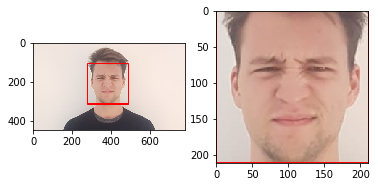

In [9]:
face = faces[0]

plt.subplot(121)
plt.imshow(img)
plt.gca().add_patch(patches.Rectangle((face[0], face[1]), face[2], face[3], fill=False, color='red'))

plt.subplot(122)
plt.imshow(img[face[1]:face[1]+face[3], face[0]:face[0]+face[2]])

In [10]:
def detect_face(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    bbox = faces[0]
    img = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    
    return img

.

# FACE ENCODING

## Transfer learning model loading

Import VGG model architecture. It will be used to transfer knwoledge from.

In [11]:
vgg_pretrained_weights = create_model()
vgg_pretrained_weights.load_weights("weights/vgg_face_weights.h5")

In [12]:
vgg_face_descriptor = Model(inputs=vgg_pretrained_weights.layers[0].input, outputs=vgg_pretrained_weights.layers[-2].output)

Before applying transfer learning, we need to preprocess image, because every model archictecture need a input format. We then define a preprocess_image function to acheive this task

In [13]:
def preprocess_image(image, n_faces=1):
    img = cv2.resize(image, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img.astype(np.float32))
    return img

## Embedding vectors

In [14]:
def embed(image_path):
    img = detect_face(image_path)
    img = preprocess_image(img)
    img = (img / 255.).astype(np.float32)
    embedded = vgg_face_descriptor.predict(img)[0,:]
    
    return embedded

In [15]:
embedded = np.zeros((metadata.shape[0],2622))

for i in tqdm(range(metadata.shape[0])):
    m = metadata[i]
    try:
        embedded[i] = embed(m.image_path())
    except IndexError:
        print(i, m.image_path())

HBox(children=(IntProgress(value=0, max=95), HTML(value='')))

3 images/train_images/Adrien_R/Adrien R (12).JPG
14 images/train_images/Adrien_R/Adrien R (6).JPG
63 images/train_images/Charles_D/Charles D (2).jpg
66 images/train_images/Charles_D/Charles D (5).jpg



Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

In [16]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

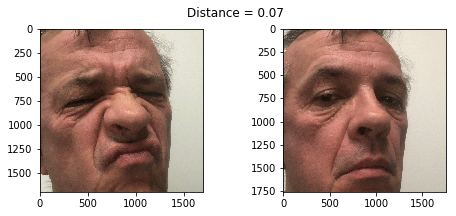

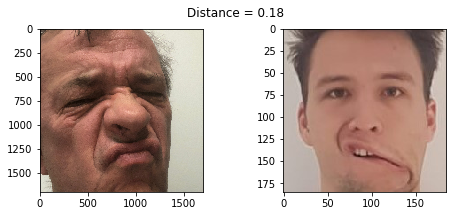

In [17]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(detect_face(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(detect_face(metadata[idx2].image_path()));    

show_pair(77, 82)
show_pair(77, 35)

As expected, the distance between the two images of the same person is smaller than the distance between two images of different people. But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

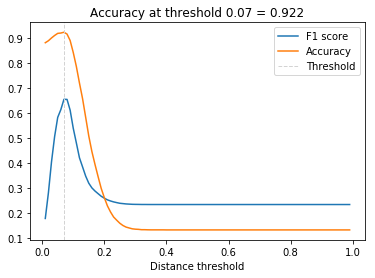

In [18]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.01, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

.

# FACE IDENTIFICATION

In [19]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9583333333333334, SVM accuracy = 0.8958333333333334


## Load Validation data

In [20]:
val_images = []
for file in os.listdir("images/val_images"):
    if "jpg" in file or "jpeg" in file or "JPG" in file:
        val_images.append(os.path.join("images", "val_images",file))

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


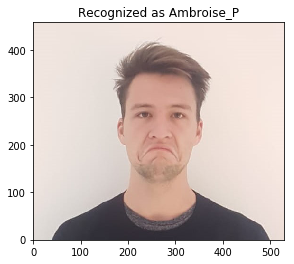

In [21]:
example_idx = 3

embedded_test = embed(val_images[example_idx])
example_prediction = svc.predict([embedded_test])
example_identity = encoder.inverse_transform(example_prediction)[0]

p = svc.decision_function(np.array([embedded_test]))
probs = np.concatenate(np.exp(p)/np.sum(np.exp(p),axis=1))

example_image = plt.imread(val_images[example_idx])
plt.imshow(np.flipud(example_image), origin='lower')

if probs.max()>0.15:
    plt.title(f'Recognized as {example_identity}');
else:
    plt.title(f'Recognized as Unknown Person')

# FEW SHOT PARADIGM

## CNN Architecture and training

In [ ]:
from model import create_model

nn4_small2 = create_model()

In [ ]:
# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.

.

# TWO FACES ON AN IMAGE

In [22]:
two_faces = []
for file in os.listdir("images/two_faces"):
    if "jpg" in file or "jpeg" in file or "JPG" in file:
        two_faces.append(os.path.join("images", "two_faces", file))

In [23]:
img = cv2.imread(two_faces[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [24]:
faces = face_cascade.detectMultiScale(gray)

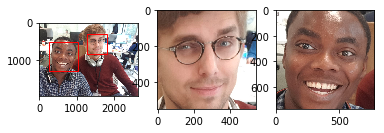

In [25]:
plt.subplot(131)
plt.imshow(img)
plt.gca().add_patch(patches.Rectangle((faces[0][0], faces[0][1]), faces[0][2], faces[0][3], fill=False, color='red'))
plt.gca().add_patch(patches.Rectangle((faces[1][0], faces[1][1]), faces[1][2], faces[1][3], fill=False, color='red'))


plt.subplot(132)
plt.imshow(img[faces[0][1]:faces[0][1]+faces[0][3], faces[0][0]:faces[0][0]+faces[0][2]])

plt.subplot(133)
plt.imshow(img[faces[1][1]:faces[1][1]+faces[1][3], faces[1][0]:faces[1][0]+faces[1][2]])

In [26]:
n_faces=2

def detect_2_faces(image_path, n_faces):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    imgs = np.array([img[faces[i][1]:faces[i][1]+faces[i][3], faces[i][0]:faces[i][0]+faces[i][2]] \
                     for i in range(n_faces)])
    
    return imgs

In [27]:
def embed_multiple(image_path, nfaces=2):
    imgs = detect_2_faces(image_path, n_faces)
    imgs = np.array([preprocess_image(imgs[i]) for i in range(n_faces)])
    imgs = (imgs / 255.).astype(np.float32)
    embedded = [vgg_face_descriptor.predict(imgs[i])[0,:] for i in range(n_faces)]
    
    return embedded

In [38]:
thresh = 0.11

def predict_image(image_path, n_faces=2):
        
    embedded_test = embed_multiple(image_path)
    example_prediction = svc.predict(embedded_test)
    identities = list((encoder.inverse_transform(example_prediction)))
    probs = []
    for i in range(n_faces):
        p = svc.decision_function(np.array([embedded_test[i]]))
        probs.append(np.concatenate(np.exp(p)/np.sum(np.exp(p),axis=1)))   
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    
    max_values = [x.max() for x in probs]
    
    people = []
    if max_values[0]>thresh:
        people.append(identities[0])
    else:
        people.append('Unknown Person')
    
    if max_values[1]>thresh:
        people.append(identities[1])
    else:
        people.append('Unknown Person')
    
    people = ' and '.join(people)
    return plt.title(f'Recognized as {people}')

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'Recognized as Benjamin_F and Charles_D')

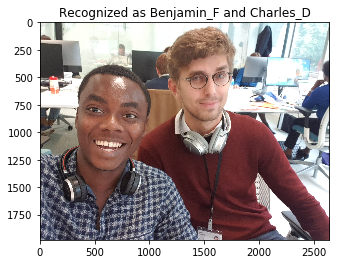

In [39]:
predict_image(two_faces[0])